In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from tqdm import tqdm, trange


nx, ny, nz = 16, 16, 16
def make_conv():
    dnn_down = nn.Sequential(
        nn.Conv1d(1, 16, 3, padding=1),
        nn.MaxPool1d(2,2),
        nn.ReLU(),
        nn.Conv1d(16, 1, 3, padding=1),
        nn.MaxPool1d(2,2))
    
    dnn_up = nn.Sequential(
        nn.ConvTranspose1d(1, 16, 2, stride=2),
        #nn.ReLU(),
        #nn.ConvTranspose1d(16, 16, 2, stride=2),
        nn.ReLU(),
        nn.ConvTranspose1d(16, 1, 2, stride=2))
    return dnn_down, dnn_up

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.dnn_down, self.dnn_up = make_conv()

    def forward(self, x):
        return self.dnn_up(self.dnn_down(x))
    
model = NeuralNetwork()

data_basepath = '/home/kjetil/projects/across/machinelearning/across_review/ert_example/'

/home/kjetil/projects/phnn_gitlab/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dnn = make_conv()

In [3]:
def generate_sample(nx, ny, nz):
    parameter = np.random.uniform(0.0, 1.0)
    x, y, z = np.mgrid[0:1:nx*1j, 0:1:ny*1j, 0:1:nz*1j]
    
    return (x + y + parameter * z).astype(np.float32).reshape(1, nx, ny, nz)

def generate_data(ns, nx, ny, nz):
    all_samples = []
    for _ in range(ns):
        all_samples.append(generate_sample(nx, ny, nz))
    
    return torch.tensor(all_samples)

def get_data(path):
    return np.loadtxt(path).reshape(1, 10*10*3)

def get_all_data_from_file(basepath):
    all_data_files = glob.glob(os.path.join(basepath, 'data/data_*.txt'))
    all_data = []
    
    for fname in all_data_files:
        new_data = get_data(fname).astype(np.float32)
        all_data.append(new_data)
    print(f"{len(all_data)=}")
    return torch.tensor(all_data)

In [4]:
data = get_all_data_from_file(data_basepath)

len(all_data)=120000


/tmp/ipykernel_897255/954534205.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return torch.tensor(all_data)


In [5]:
print(f"{model.forward(data).shape=}")
print(f"{data.shape=}")
print(f"{nn.MSELoss()(model.forward(data), data)=}")

model.forward(data).shape=torch.Size([120000, 1, 300])
data.shape=torch.Size([120000, 1, 300])
nn.MSELoss()(model.forward(data), data)=tensor(144394.7656, grad_fn=<MseLossBackward0>)


In [6]:
data.shape

torch.Size([120000, 1, 300])

100%|█████████| 100/100 [20:02<00:00, 12.02s/it, epoch=100, shape=torch.Size([32, 1, 300]), train_loss=2.08e+3]


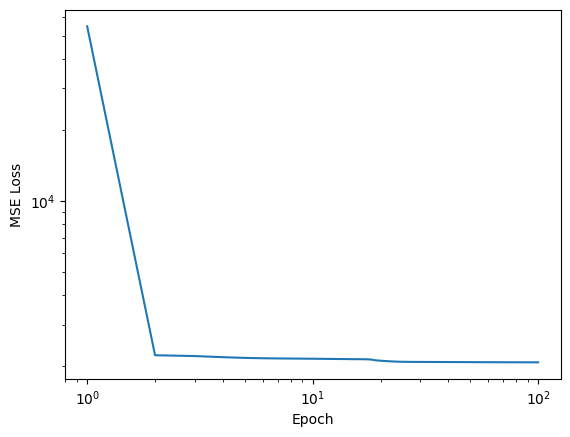

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 100
loss_function = nn.MSELoss()
train_loader = torch.utils.data.DataLoader(data, batch_size=32, num_workers=0)
loss_per_epoch = []
with trange(1, n_epochs + 1) as t:
    for epoch in t:
        train_loss = 0.0

        for samples in train_loader:
            optimizer.zero_grad()
            outputs = model(samples)
            loss = loss_function(outputs, samples)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*samples.size(0)

        train_loss = train_loss/len(train_loader)
        t.set_postfix(epoch=epoch, train_loss=train_loss, shape=samples.shape)
        loss_per_epoch.append(train_loss)
        
plt.loglog(np.arange(1, n_epochs+1), loss_per_epoch)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

In [8]:
x = torch.tensor(np.zeros((4,5)))

In [9]:
model.dnn_down(data[0, :, :]).shape

torch.Size([1, 75])